<a href="https://colab.research.google.com/github/lyradsouza/BreakthroughAI_Practice/blob/main/module6(Lyra)_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6 - Deep Learning 1

The goal of this week's lab is to learn what a deep neural network is and how it relates to previous linear models. We are going to build networks today that can automatically learn to adapt to very complex shapes.

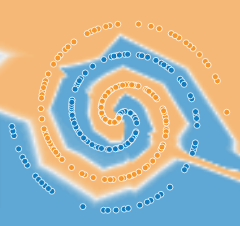

In the past two weeks we used a simple linear model for classification. In practice however, many datasets are not linearly separable,
i.e., not all classification problems can be solved by a linear classifier, as we saw earlier on the circle dataset.

Deep neural networks provide a way to learn flexible shapes without specifying features.
This is achieved by stacking multiple layers on top of each others.

Deep neural networks form the backbone of deep learning approaches, which have seen tremendous successes in applications such as machine translation,
document summarization, image classification, and speech recognition.

Here is a video of a neural network generating faces.

[Face Generation](https://youtu.be/XOxxPcy5Gr4)

This week we will walk through the basics of deep neural networks.

* **Review**: Linear Classifiers and Features
* **Unit A**: TensorFlow, Training Linear Classifiers 
* **Unit B**: Neural Networks

## Review

Last time we trained a linear classifier for binary classification.

In [ ]:
import altair as alt
import pandas as pd
import sklearn.linear_model

We will also turn off warnings.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Step 1. Create our data.
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/circle.csv")
df_train = df.loc[df["split"] == "train"]
df_test = df.loc[df["split"] == "test"]

Step 2. Create a linear model and fit it to data.

In [ ]:
model = sklearn.linear_model.LogisticRegression()
model.fit(X=df_train[["feature1", "feature2"]],
          y=df_train["class"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Step 3. Predict.

In [ ]:
df_test["predict"] = model.predict(df_test[["feature1", "feature2"]])

We can see that the linear classifier fails to classify some data points due to its being linear.

In [ ]:
correct = (df_test["predict"] ==  df_test["class"])
df_test["correct"] = correct
chart = (alt.Chart(df_test)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "class",
        fill = "predict",
        tooltip = ["correct"]
    ))
chart

alt.Chart(...)

We can improve on this approach by adding a new feature column.

In [ ]:
def mkdistance(row):
    f1 = row["feature1"] - 0.5
    f2 = row["feature2"] - 0.5
    return f1*f1 + f2*f2

In [ ]:
# We add it to the model with either `map` or `apply`.
df_train["feature3"] = df_train.apply(mkdistance, axis=1)
df_test["feature3"] = df_test.apply(mkdistance, axis=1)

If instead we fit with the new features

In [ ]:
model.fit(X=df_train[["feature2", "feature3"]],
          y=df_train["class"] == "red")
df_test["predict"] = model.predict(df_test[["feature2", "feature3"]])

In [ ]:
chart = (alt.Chart(df_test)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "class",
        fill = "predict",
        tooltip = ["correct"]
    ))
chart

alt.Chart(...)

In [ ]:
# We can also check the behavior of our classifier on all possible inputs.
all_df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/all_points.csv")
all_df["feature3"] = all_df.apply(mkdistance, axis=1)
all_df["predict"] = model.predict(all_df[["feature2", "feature3"]])
chart = (alt.Chart(all_df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="predict",
        fill = "predict",
    ))
chart

alt.Chart(...)

Remember though this is because we changed the features. The model is
still a linear seperator in the new features.

In [ ]:
chart = (alt.Chart(df_test)
    .mark_point()
    .encode(
        x = "feature2",
        y = "feature3",
        color = "class",
        fill = "predict",
        tooltip = ["correct"]
    ))
chart

alt.Chart(...)

We can do the same thing for other datasets.

In [ ]:
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/center.csv")

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "class"
    ))
chart

alt.Chart(...)

### Review Exercise

Add new features and make predictions on this df dataset. 

In [ ]:
#📝📝📝📝 FILLME
def mkfeature(row):
    return abs(row["feature1"] - 0.5)
   

df["feature3"] = df.apply(mkfeature, axis=1)

model.fit(X=df[["feature1", "feature2", "feature3"]], y=df["class"] == "red")
df["predict"] = model.predict(df[["feature1", "feature2", "feature3"]])

Graph the result

📝📝📝📝 FILLME

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "class",
        fill = "predict"
    ))
chart

alt.Chart(...)

## Unit A

### Linear Models in TensorFlow

Linear classifiers can only produce linear "decision boundaries", i.e., there is a line such that points on one side of the line
are classified as one class, whereas points on the other side are classified as the other class.

Last class we got around this issue by telling the ML system what shapes we wanted. However this required us to know enough about the problem to specify what these were.

For today's class we are going to extend our model such that it can produce more general shapes without requiring us to tell it what they are.

We will do this with a library known as TensorFlow. TensorFlow is the main library
that companies doing machine learning use. When people talk about AI these days they are often talking about machine learning with TensorFlow.

To get started we will need these imports. We will use TensorFlow through a library known as Keras.

In [ ]:
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation

The first thing we will do is rebuild our LinearClassifier in Keras.

We also need a function to create model, which is required for building a general `KerasClassifier`.

In [ ]:
def create_model(rate=1.0):
    # Makes it the same for everyone in class
    tf.random.set_seed(2)
    
    # Create model 
    model = Sequential()
    model.add(Dense(1, activation="sigmoid")) # Linear Classifier

    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=rate
    )
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

Next, we use `KerasClassifier` to turn a TensorFlow model into one
that can be used by Scikit Learn. We have to give it a couple of
arguments to get it started.

In [ ]:
model = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        batch_size=20,
                        verbose=False)

Lastly, we fit the classifier on training data and apply it to all points to check the shape of its decision boundary.

Load the data.

In [ ]:
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/simple.csv")

This part is the same as Scikit-Learn.

In [ ]:
model.fit(x=df[["feature1", "feature2"]],
          y=(df["class"] == "red"))
df["predict"] = model.predict(df[["feature1", "feature2"]])

Pretty good classification.

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict",
    ))
chart

alt.Chart(...)

This leads to the same answer but let's us play with the details.

### Visualizing Linear Training

We construct this model to give us a better sense of what it is that
we are doing when we do linear training.

A benefit of TensorFlow is that it provides a way to influence
the internal decisions made during the training process and build
different models.

To get a sense how this works, let us look at the TensorFlow playground.

[Tensorflow Playground](https://playground.tensorflow.org/)

This is a tool that allows us to build different machine learning models
and play with them in the browser.

Here is an example that looks like our linear model. Press the `Play` button to run it. 

[Example 1](https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.0001&regularizationRate=0&noise=0&networkShape=&seed=0.28207&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

There are several things to look at in the tool.

1. Try clicking on a different Dataset to see how it is difficult for the linear model to fit it.
2. Try altering the features to see how some of the tricks that we used last week (squares and sines) help fix this issue.
3. Look at the `Output` graph above the points on the right. What is that graph showing. 

### What is training?

Now let us look at what happens when we build a tool like this
ourselves. This is the stuff that gets done automatically for us
inside everything we have see so far.

In [ ]:
model = create_model()

We first make our features and target class. We then convert them to
TensorFlow format.

In [ ]:
X = df[["feature1", "feature2"]]
y = df["class"] == "red"
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

The key thing a model needs to compute is the `loss`. This tells us
how well the model is currently doing.

Roughly the loss is a numerical value that counts how many points are
on each side of the line, and how far they are. 

This is the graph that we saw in the browser version of the tool.

In [ ]:
loss = model.compiled_loss(y, model(X))
print(loss)

tf.Tensor(0.8267381, shape=(), dtype=float32)


If we graph it, we can see that it is not doing well.  Many of the points are on the wrong side of the line.

In [ ]:
all_df["predict"] = model.predict(all_df[["feature1", "feature2"]]) > 0.5

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
    ))
chart2 = (alt.Chart(all_df)
    .mark_point(color="white")
    .encode(
        x = "feature1",
        y = "feature2",
        fill = "predict",
    ))
chart2 + chart

alt.LayerChart(...)

Inside the model there are a collections of `parameters`. By
adjusting these, we can make the loss go up or down. For example in
our model there are 3 trainable parameters.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


To improve our model, we need to adjust the line to minimize the
loss function. This can be done using basic calculus and
derivatives. The system computes derivatives to try to make the
loss better. 

While we don't have time to go into details, you can read more about the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm that is used.

The below code takes one step of gradient descent and adjusts the parameters of the model.

In [ ]:
pick = []
for i in range(50):
    # Compute loss
    with tf.GradientTape() as tape: 
        loss = model.compiled_loss(y, model(X, training=True))

    # Compute derivatives
    gradients = tape.gradient(loss, model.trainable_variables)

    # Adjust parameters
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Save for graphing.
    if i % 2 == 0:
        t = all_df.copy()
        t["predict"] = model.predict(all_df[["feature1", "feature2"]]) > 0.5
        pick.append(t)

Here we can see all the graphs. See how it gets better each time.

In [ ]:
vc = alt.vconcat()
for p in pick: 
    chart2 = (alt.Chart(p)
              .mark_point(color="white")
              .encode(
                  x = "feature1",
                  y = "feature2",
                  fill = "predict" 
              ))
    vc &= (chart2 + chart)
vc

To be more specific, we adjust the parameters opposite the direction of the gradient of the loss with respect to them.
Doing so decreases the loss if we are cautious enough to take a small adjustment at a time.

# Group Exercise A

## Question 0

Icebreakers

Who are other members of your group today?

📝📝📝📝 Kera, Esther, and Puja

* What sport would they compete in if they were in the Olympics?

📝📝📝📝 Esther would compete in skateboarding, Kera in ping pong, and Puja in swimming.

* Do they prefer Popcorn or M&Ms?

📝📝📝📝 Esther prefers popcorn, Kera preders m&ms, and Puja also prefers popcorn.

## Question 1

For this question we will use the TensorFlow Playground

[Tensorflow Playground](https://playground.tensorflow.org/)

* Try changing the learning rate. What happens when it is really low? What happens when it is really high?

In [ ]:
#📝📝📝📝 FILLME
# A really low learning rate resulted in a very slow but more accurate model, with test loss and training loss falling pretty low, 
# but requiring many, many epochs to achieve this accuracy.
# A really high learning rate resulted in a speedy but more unpredictable model. For easier data sets the prediction happened 
# quickly and accurately, but for more complex data, after decreasing for a short period of time, the test and training loss 
# would start increasing and the model would be wildly inaccurate."

* On the left hand side there is a noise bar. What happens when you move that? Does this make things easier or harder?  

In [ ]:
#📝📝📝📝 FILLME
# Higher noise resulted in more misclassified points, so things were a little harder for the model since it had to 
# make sure not to overfit the training data but then also then couldn't create a clean and definitive separation 
# between all the blue and orange points.

* Can you get some of the harder datasets using different features? Which ones can you get right?

In [ ]:
#📝📝📝📝 FILLME
# We got the four quadrants (in the upper right corner of the data selection) can be achieved using features x1, x2, and x1x2. 
# We also got the concentric circles (in the upper left corner) can be achieved very cleanly using quite a few 
# features: x1, x2, x1^2, x2^2, and x1x2.
# We coudlnt get the spiral.

## Question 2

Now it's a good time for us to look back at how we created and trained a `KerasClassifier` before.
Do you understand what's happening behind the scene now?

In [ ]:
model = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        rate=1.00,
                        batch_size=20,
                        verbose=False)
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/simple.csv")

Try training the copying the model 3 times with the following settings on train and give the accuracy on test. 

1. Learning rate 0.01
2. Epochs 5
3. Batch Size 1

In [ ]:
import time

model = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        rate=1.00,
                        batch_size=20,
                        verbose=False)

start = time.time()
model.fit(x=df[["feature1", "feature2"]],
          y=(df["class"]))
df["predict"] = model.predict(df[["feature1", "feature2"]])

print("Original model time: " + str(time.time() - start))

Original model time: 1.542529582977295


In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict",
    ))
chart

alt.Chart(...)

In [ ]:
#📝📝📝📝 FILLME
model1 = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        rate=0.01,
                        batch_size=20,
                        verbose=False)

start = time.time()
model1.fit(x=df[["feature1", "feature2"]],
          y=(df["class"]))
df["predict1"] = model1.predict(df[["feature1", "feature2"]])

print("Model 1 time: " + str(time.time() - start))

Model 1 time: 0.9316673278808594


In [ ]:
chart1 = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict1",
    ))
chart1

alt.Chart(...)

In [ ]:
model2 = KerasClassifier(build_fn=create_model,
                        epochs=5,
                        rate=1.00,
                        batch_size=20,
                        verbose=False)

start = time.time()
model2.fit(x=df[["feature1", "feature2"]],
          y=(df["class"]))
df["predict2"] = model2.predict(df[["feature1", "feature2"]])

print("Model 2 time: " + str(time.time() - start))

Model 2 time: 0.9341604709625244


In [ ]:
chart2 = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict2",
    ))
chart2

alt.Chart(...)

In [ ]:
model3 = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        rate=1.00,
                        batch_size=1,
                        verbose=False)

start = time.time()
model3.fit(x=df[["feature1", "feature2"]],
          y=(df["class"]))
df["predict3"] = model3.predict(df[["feature1", "feature2"]])

print("Model 3 time: " + str(time.time() - start)) 

Model 3 time: 1.9737217426300049


In [ ]:
chart3 = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict3",
    ))
chart3

alt.Chart(...)

In [ ]:
df["correct"] = df["class"] == df["predict"]
df["correct1"] = df["class"] == df["predict1"]
df["correct2"] = df["class"] == df["predict2"]
df["correct3"] = df["class"] == df["predict3"]

print("Original model: " + str(df["correct"].sum() / len(df["predict"])))
print("Model 1: " + str(df["correct1"].sum() / len(df["predict1"])))
print("Model 2: " + str(df["correct2"].sum() / len(df["predict2"])))
print("Model 3: " + str(df["correct3"].sum() / len(df["predict3"])))

Original model: 0.9533333333333334
Model 1: 0.4266666666666667
Model 2: 0.96
Model 3: 0.9933333333333333


Which scores the best? Which is the fastest?

Model 3 (batch size of 1) had the highest accuracy score and model 2 (5 epochs) was the fastest.



## Question 3

Run the classifier with `verbose` equal to True. This will print out a lot of additional
information

In [ ]:
model = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        batch_size=20,
                        verbose=True)

model.fit(x=df[["feature1", "feature2"]],
          y=(df["class"] == "red"))
df["predict"] = model.predict(df[["feature1", "feature2"]])

Epoch 1/10
8/8 [==============================] - 1s 2ms/step - loss: 0.7534 - accuracy: 0.4746
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.6821
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.7154
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5623 - accuracy: 0.8605
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5037 - accuracy: 0.8125
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.9189
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.8358
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.8697
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.9471
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


Describe in words what each part of the output means.

📝📝📝📝 Each of the epochs represents an iteration through through the model, and there are 10 in total. We then see the total time for each epoch is the step time, so 1s 2ms for the first epoch, then only few milliseconds for the ones after. The loss gives the result of applying the loss function to our model, and it goes down over time as the model learns the data better, while the accuracy score comes from comparing the predicted values output by the model to the actual data points.

# Unit B

## Back to the Playground

In this unit we are going to explore how neural networks can learn
to produce some of the features from last class automatically.

Do you remember last class how we had this graph?

In [ ]:
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/complex.csv")

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "class"
    ))
chart

alt.Chart(...)

We saw that this shape was hard for our linear model to
learn. Instead we introduced a feature that cut off the
top and the bottom. This made it possible for us to learn
a linear model. 

Let us see how a neural network can handle this problem. 

[Example 2](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.42314&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

This model is able to separate out the points without us telling it the features. Because it can do it by itself, we call it a "feature learning" model.

Note that this model has two stages, one that decides on the features and one that decides on the final separation. Because of this we call it a Multi-Layer model.

Let us look back at the playground. If we mouse over the hidden layers, we can see that they each correspond to a linear split. This linear split is how the model decides on the intermediate features.

For instance, do you remember the feature from last week that looked like this? That is exactly the kind of intermediate feature that a model like this would learn. 

In [ ]:
def mkupperfeature(row):
    if row["feature1"] <= 0.5:
        return -1.0
    else:
        return row["feature1"]

In [ ]:
all_df["feature3"] = all_df.apply(mkupperfeature, axis=1)

In [ ]:
chart = (alt.Chart(all_df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color = "feature3:Q"
    ))
chart

alt.Chart(...)

The same approach can be used for more complex figures like our circle. 

[Example 3](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.43804&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

## Coding Multiple Layers

At its heart, TensorFlow is a library for allowing us to build
stacks of multiple-layers.

Let's directly go to the code and add one more layer to our model.

In [ ]:
def create_multi_model(rate=0.03):
    # create model
    tf.random.set_seed(2)
    model = Sequential()
    model.add(Dense(10, activation="relu")) # the new layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=rate
    )

    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In the above code, we added a linear layer `Dense(4)` which is one
hidden layer size 4, and then `Dense(1)` which makes our prediction.

👩‍🎓**Student question: Can you make this example in the playground?**

[Playground](https://playground.tensorflow.org)

As before, we create the model, fit it on the training data, and
finally apply it to all points to check the shape of its decision
boundary.

In [ ]:
model = KerasClassifier(build_fn=create_multi_model, 
                        epochs=20,
                        batch_size=20,
                        verbose=False)

Finally we fit it the same way as before.

In [ ]:
model.fit(x=df[["feature1", "feature2"]],
          y=df["class"]=="red")
df["predict"] = model.predict(df[["feature1", "feature2"]])

Let us look at what this model looks like.

In [ ]:
model.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


And make the chart.

In [ ]:
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict",
    ))
chart

alt.Chart(...)

# Group Exercise B

## Question 1

For this question, you will use the TensorFlow Playground.

[Tensorflow Playground](https://playground.tensorflow.org/)

* There is an option at the top to change the `Activation`. What do each of these do to the output shape?

📝📝📝📝 FILLME - Using ReLU as the activation function resulted in a much more more linear shape, the shape surrounding the circle was more like a polygon.
The tanh function was very sinuous and resulted in either a circular/oblong or pear-shaped central shape around the circle.
The sigmoid function was also more sinuous, but though I tried to run it multiple times, it seemed to struggle to form the correct shape in conjunction with the other settings provided. 
The linear activation function was, as implied by the name, a line, and couldn't form an accurate prediction for the circular data. 

* Can you make different number of layers to get some of the harder examples? Can you get the spiral?

📝📝📝📝 FILLME - We managed to get the four quadrants with two hidden layers with two neurons each but also with one hidden layer of four neurons. We also did manage to get the spiral! Using 6 hidden layers with a total of 8 neurons in each layer, we were able to get the spiral with a decent test and training loss.

* When you get the spiral, what shape do the hidden layers use to help separate? Can you screenshot a picture? 

📝📝📝📝 The hidden layers help by coming together to form curves using an accretion of many line segments. It's interesting to see how the shapes in the neurons begin more linear and gradually begin forming more complex shapes with nested circles and curves. The layering of different colors in nested curves seems to be separated out using many iterations of combining increasingly complex shapes from lines and curves that just separate red and blue to pockets of red and blue overlapping with each other to the final spiral. 

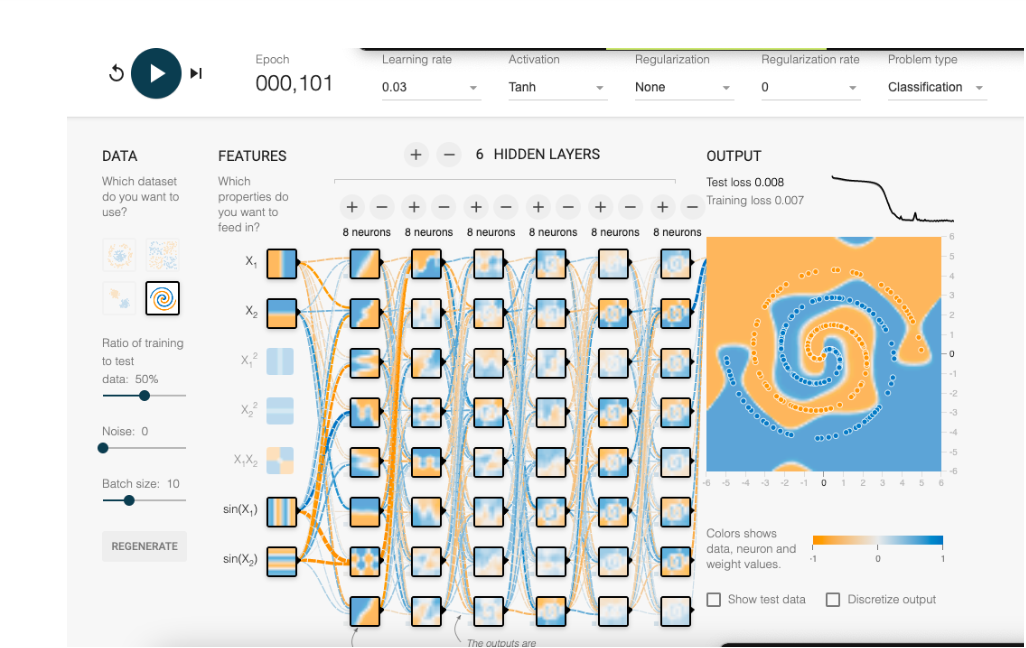


## Question 2

Can you further improve the above model to achieve even better accuracy?
Hint: try stacking more layers.

In [ ]:
def create_model(rate=0.03):
    tf.random.set_seed(2)
    # create model
    model = Sequential()
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))

    # add more 
    model.add(Dense(30, activation="relu"))
    model.add(Dense(30, activation="relu"))

    model.add(Dense(1, activation="sigmoid"))
    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=rate
    )

    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model,
                         epochs=100,
                         batch_size=20,
                         verbose=0)

📝📝📝📝 FILLME - Train and test model

In [ ]:
model.fit(x=df[["feature1", "feature2"]], y=df["class"]=="red")
df["predict"] = model.predict(df[["feature1", "feature2"]])

chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
        fill = "predict",
    ))
chart

alt.Chart(...)

In [ ]:
df["correct"] = ((df["class"]=="red") == df["predict"])
print(df["correct"].sum()/len(df["correct"]))

0.98


## Question 3

We can apply a model to predict whether a city's temperature is over 20 degrees celsius,
based on its latitude, the month and year of the query date. We provide basic data processing and a
naive baseline below

In [ ]:
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/data/Temperatures.csv", index_col=0, parse_dates=[1]) # load data
df.dropna() # drop rows containing empty values
filter_train = (df["dt"].dt.year >= 1950) & (df["dt"].dt.year <= 2000) # use data between 1950 and 2000 for training
filter_test = (df["dt"].dt.year > 2000) #  use data after 2000 for test
df["Month"] = df["dt"].dt.month # add feature Month
df["Year"] = df["dt"].dt.year # add feature Year
df["class"] = df["AverageTemperature"] > 20 # the label we want to predict, whether temperature is over 20 degrees
df_train = df.loc[filter_train]
df_test = df.loc[filter_test]
out = df_train.describe()
out

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Month,Year
count,18972.000000,18972.000000,18972.000000,18972.000000,18972.00000,18972.000000
mean,16.435727,0.341187,28.526022,-92.636882,5.50000,1975.000000
std,8.885081,0.144655,14.781476,32.549551,3.35419,14.719989
min,-29.154000,0.058000,-37.780000,-123.460000,1.00000,1950.000000
25%,11.740750,0.244000,20.090000,-104.080000,3.25000,1962.000000
50%,17.862000,0.316000,29.740000,-98.030000,5.50000,1975.000000
75%,22.584000,0.410000,39.380000,-85.420000,7.75000,1988.000000
max,33.591000,1.853000,53.840000,174.920000,10.00000,2000.000000


We can visualize our data in different ways.

In [ ]:
chart = alt.Chart(df_train.sample(n=500)).mark_point().encode(
    y = "Latitude",
    x = "Month:O",
    color = "class",
    fill = "class",
    tooltip=["City"],
)
chart

alt.Chart(...)

In [ ]:
chart = alt.Chart(df_train.sample(n=500)).mark_point().encode(
    y = "Latitude",
    x = "Year:O",
    color = "class",
    fill = "class",
    tooltip=["City"],
)
chart

alt.Chart(...)

Now it's your turn to develop a model! What accuracy can you get?
We recommend using a smaller number of epochs by setting `epochs=1` in `KerasClassifier` to make training faster.

In [ ]:
#📝📝📝📝 FILLME
def create_model(rate=0.0001):
    # create model
    tf.random.set_seed(2)
    model = Sequential()

    model.add(Dense(32, activation="relu")) 
    model.add(Dense(32, activation="relu")) 


    model.add(Dense(1, activation="sigmoid"))
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=rate
    )

    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model,
                        epochs=10,
                        batch_size=5,
                        verbose=1)
model.fit(x=df_train[["Latitude", "Month", "Year"]], y=df_train["class"])
df_test["predict"] = model.predict(df_test[["Latitude", "Month", "Year"]])
correct = (df_test["predict"] ==  df_test["class"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

Epoch 1/10
3795/3795 [==============================] - 6s 1ms/step - loss: 4.2937 - accuracy: 0.5782
Epoch 2/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.6224 - accuracy: 0.6468
Epoch 3/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5972 - accuracy: 0.6731
Epoch 4/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.6190 - accuracy: 0.6562
Epoch 5/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5965 - accuracy: 0.6711
Epoch 6/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5972 - accuracy: 0.6692
Epoch 7/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5899 - accuracy: 0.6781
Epoch 8/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5937 - accuracy: 0.6722
Epoch 9/10
3795/3795 [==============================] - 5s 1ms/step - loss: 0.5919 - accuracy: 0.6742
Epoch 10/10
949/949 [==============================] - 1s 1ms/step
accuracy:  0.63